In [1]:
# General imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.preprocessing import MultiLabelBinarizer

pd.option_context('display.float_format', '{:0.2f}'.format)

SOURCE_PATH = "/srv/workspace/research/user_based_contexts_tagging/"
SPECTROGRAMS_PATH = "/srv/workspace/research/user_based_contexts_tagging/dataset/"
OUTPUT_PATH = "/srv/workspace/research/user_based_contexts_tagging/experiments_results/"

LABELS_LIST = ['car', 'chill', 'club', 'dance', 'gym', 'happy',
       'night', 'party', 'relax', 'running', 'sad', 'sleep', 'summer', 'work','workout']

In [14]:
def mark_groups_for_samples(df, n_samples, extra_criterion):
    """
        Return groups, an array of size n_samples, marking the group to which each sample belongs
        The default group is -1 if extra_criterion is None
        If a criterion is given (artist or album), then this information is taken into account
    """
    groups = np.array([-1 for _ in range(n_samples)])
    if extra_criterion is None:
        return groups

    if extra_criterion == "artist":
        crit_col = "artist_id"
    elif extra_criterion == "album":
        crit_col = "releasegroupmbid"
    else:
        return groups

    gp = df.groupby(crit_col)
    i_key = 0
    for g_key in gp.groups:
        samples_idx_per_group = gp.groups[g_key].tolist()
        groups[samples_idx_per_group] = i_key
        i_key += 1
    return groups


def select_fold(index_label, desired_samples_per_label_per_fold, desired_samples_per_fold, random_state):
    """
        For a label, finds the fold where the next sample should be distributed
    """
    # Find the folds with the largest number of desired samples for this label
    largest_desired_label_samples = max(desired_samples_per_label_per_fold[:, index_label])
    folds_targeted = np.where(desired_samples_per_label_per_fold[:, index_label] == largest_desired_label_samples)[0]

    if len(folds_targeted) == 1:
        selected_fold = folds_targeted[0]
    else:
        # Break ties by considering the largest number of desired samples
        largest_desired_samples = max(desired_samples_per_fold[folds_targeted])
        folds_re_targeted = np.intersect1d(np.where(
            desired_samples_per_fold == largest_desired_samples)[0], folds_targeted)

        # If there is still a tie break it picking a random index
        if len(folds_re_targeted) == 1:
            selected_fold = folds_re_targeted[0]
        else:
            selected_fold = random_state.choice(folds_re_targeted)
    return selected_fold


def iterative_split(df, out_file, target, n_splits, extra_criterion=None, seed=None):
    """
        Implement iterative split algorithm
        df is the input data
        out_file is the output file containing the same data as the input plus a column about the fold
        n_splits the number of folds
        target is the target source for which the files are generated
        extra_criterion, an extra condition to be taken into account in the split such as the artist
    """
    print("Starting the iterative split")
    random_state = check_random_state(seed)

    mlb_target = MultiLabelBinarizer()
    M = mlb_target.fit_transform(df[target].str.split('\t'))

    n_samples = len(df)
    n_labels = len(mlb_target.classes_)

    # If the extra criterion is given create "groups", which shows to which group each sample belongs
    groups = mark_groups_for_samples(df, n_samples, extra_criterion)

    ratios = np.ones((1, n_splits)) / n_splits
    # Calculate the desired number of samples for each fold
    desired_samples_per_fold = ratios.T * n_samples

    # Calculate the desired number of samples of each label for each fold
    number_samples_per_label = np.asarray(M.sum(axis=0)).reshape((n_labels, 1))
    desired_samples_per_label_per_fold = np.dot(ratios.T, number_samples_per_label.T)  # shape: n_splits, n_samples

    seen = set()
    out_folds = np.array([-1 for _ in range(n_samples)])

    count_seen = 0
    print("Going through the samples")
    while n_samples > 0:
        # Find the index of the label with the fewest remaining examples
        valid_idx = np.where(number_samples_per_label > 0)[0]
        index_label = valid_idx[number_samples_per_label[valid_idx].argmin()]
        label = mlb_target.classes_[index_label]

        # Find the samples belonging to the label with the fewest remaining examples
        # second select all samples belonging to the selected label and remove the indices
        # of the samples which have been already seen
        all_label_indices = set(M[:, index_label].nonzero()[0])
        indices = all_label_indices - seen
        assert (len(indices) > 0)

        print(label, index_label, number_samples_per_label[index_label], len(indices))

        for i in indices:
            if i in seen:
                continue

            # Find the folds with the largest number of desired samples for this label
            selected_fold = select_fold(index_label, desired_samples_per_label_per_fold,
                                        desired_samples_per_fold, random_state)

            # put in this fold all the samples which belong to the same group
            idx_same_group = np.array([i])
            if groups[i] != -1:
                idx_same_group = np.where(groups == groups[i])[0]

            # Update the folds, the seen, the number of samples and desired_samples_per_fold
            out_folds[idx_same_group] = selected_fold
            seen.update(idx_same_group)
            count_seen += idx_same_group.size
            n_samples -= idx_same_group.size
            desired_samples_per_fold[selected_fold] -= idx_same_group.size

            # The sample may have multiple labels so update for all
            for idx in idx_same_group:
                all_labels = M[idx].nonzero()
                desired_samples_per_label_per_fold[selected_fold, all_labels] -= 1
                number_samples_per_label[all_labels] -= 1

    df['fold'] = out_folds
    #df.drop("index", axis=1, inplace=True)
    print(count_seen, len(df))
    df.to_csv(out_file, sep=',', index=False)
    return df


def split_dataset(groundtruth,
                  test_size=0.25, seed=0, save_csv=True, n_splits=4,
                  train_save_path=os.path.join(SOURCE_PATH, "GroundTruth/"),
                  test_save_path=os.path.join(SOURCE_PATH, "GroundTruth/"),
                  validation_save_path=os.path.join(SOURCE_PATH, "GroundTruth/"),
                  folds_save_path=os.path.join(SOURCE_PATH, "GroundTruth/ground_truth_folds.csv")):
    #groundtruth = pd.read_csv(csv_path)

    groundtruth_folds = iterative_split(df=groundtruth, out_file=folds_save_path, target='label',
                                        n_splits=n_splits, extra_criterion='user_id', seed=seed)
    test = groundtruth_folds[groundtruth_folds.fold == 0]
    train_validation_combined = groundtruth_folds[groundtruth_folds.fold.isin(np.arange(1, n_splits))]
    train, validation = train_test_split(train_validation_combined, test_size=0.1, random_state=seed)
    train.drop(["fold"], axis=1, inplace=True)
    test.drop(["fold"], axis=1, inplace=True)
    validation.drop(["fold"], axis=1, inplace=True)
    # train, test = train_test_split(train, test_size=test_size, random_state=seed)
    if save_csv:
        pd.DataFrame.to_csv(train, os.path.join(train_save_path, "train_ground_truth.csv"), index=False)
        pd.DataFrame.to_csv(validation, os.path.join(validation_save_path, "validation_ground_truth.csv"), index=False)
        pd.DataFrame.to_csv(test, os.path.join(test_save_path, "test_ground_truth.csv"), index=False)
    # Save data in binarized format as well
    mlb_target = MultiLabelBinarizer()
    M = mlb_target.fit_transform(test.label.str.split('\t'))
    Mdf = pd.DataFrame(M, columns=LABELS_LIST)
    test.reset_index(inplace=True, drop=True)
    test_binarized = pd.concat([test, Mdf], axis=1)
    test_binarized.drop(['label'], inplace=True, axis=1)
    # For validation
    mlb_target = MultiLabelBinarizer()
    M = mlb_target.fit_transform(validation.label.str.split('\t'))
    Mdf = pd.DataFrame(M, columns=LABELS_LIST)
    validation.reset_index(inplace=True, drop=True)
    validation_binarized = pd.concat([validation, Mdf], axis=1)
    validation_binarized.drop(['label'], inplace=True, axis=1)
    # for training
    mlb_target = MultiLabelBinarizer()
    M = mlb_target.fit_transform(train.label.str.split('\t'))
    Mdf = pd.DataFrame(M, columns=LABELS_LIST)
    train.reset_index(inplace=True, drop=True)
    train_binarized = pd.concat([train, Mdf], axis=1)
    train_binarized.drop(['label'], inplace=True, axis=1)
    if save_csv:
        pd.DataFrame.to_csv(test_binarized, os.path.join(test_save_path, "test_ground_truth_binarized.csv"),
                            index=False)
        pd.DataFrame.to_csv(validation_binarized,
                            os.path.join(validation_save_path, "validation_ground_truth_binarized.csv"), index=False)
        pd.DataFrame.to_csv(train_binarized, os.path.join(train_save_path, "train_ground_truth_binarized.csv"),
                            index=False)
    return train, validation, test




In [3]:
global_labels = pd.read_pickle("/srv/workspace/research/user_based_contexts_tagging/GroundTruth/ground_truth_hot_vector.pkl")
global_labels.drop(["train","shower","morning"],inplace=True,axis=1)
global_labels = global_labels[~(global_labels.iloc[:,2:] == 0).all(axis = 1)]
global_labels.iloc[:,2:] = global_labels.iloc[:,2:].clip(upper=1, axis=1)

In [4]:
mlb = MultiLabelBinarizer()
mlb.fit([LABELS_LIST])
labels = mlb.inverse_transform(global_labels.values[:,2:])
labels_listed = ['\t'.join(label) for label in labels] 
groundtruth = global_labels
groundtruth['label'] = labels_listed
groundtruth.drop(LABELS_LIST,axis = 1,inplace=True)

In [5]:
csv_path=os.path.join(SOURCE_PATH, "GroundTruth/ground_truth_hot_vector.csv")
test_size=0.25 
seed=0 
save_csv=True 
n_splits=4
train_save_path=os.path.join(SOURCE_PATH, "GroundTruth/")
test_save_path=os.path.join(SOURCE_PATH, "GroundTruth/")
validation_save_path=os.path.join(SOURCE_PATH, "GroundTruth/")
folds_save_path=os.path.join(SOURCE_PATH, "GroundTruth/ground_truth_folds.csv")

In [15]:
groundtruth_folds = split_dataset(groundtruth)

Starting the iterative split
Going through the samples
sleep 11 [111679] 111679
club 2 [118273] 118273
happy 5 [194439] 194439
work 13 [223878] 223878
car 0 [234629] 234629
night 6 [237239] 237239
workout 14 [259587] 259587
gym 4 [307613] 307613
relax 8 [326514] 326514
running 9 [349913] 349913
sad 10 [373917] 373917
summer 12 [487190] 487190
party 7 [802754] 802754
dance 3 [1097611] 1097611
chill 1 [1298145] 1298145
6423381 6423381


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
test_binarized = pd.read_csv(os.path.join(test_save_path, "test_ground_truth_binarized.csv"))

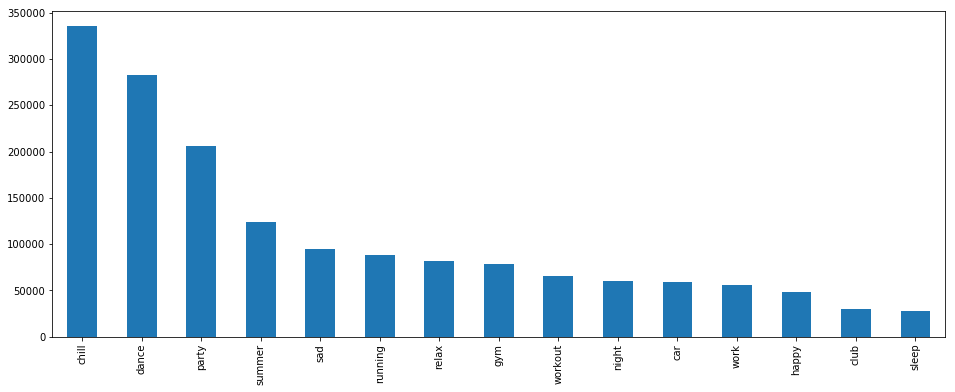

In [21]:
test_binarized.iloc[:,2:].sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(16,6))

In [22]:
train_binarized = pd.read_csv(os.path.join(test_save_path, "train_ground_truth_binarized.csv"))

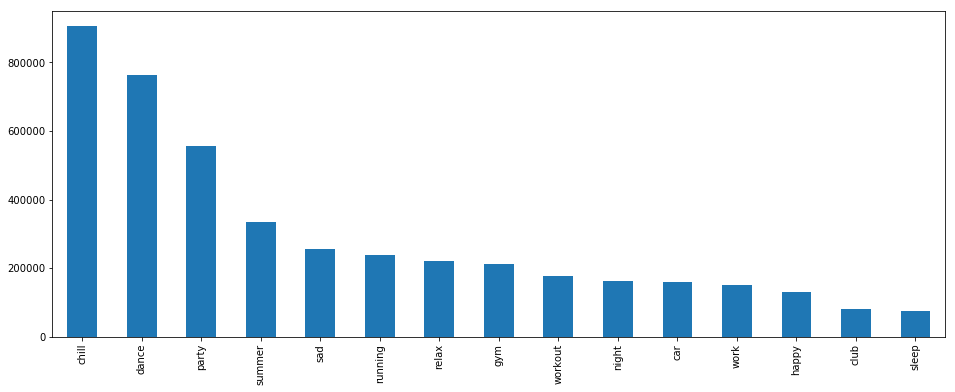

In [23]:
train_binarized.iloc[:,2:].sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(16,6))

In [32]:
global_labels = pd.read_csv(os.path.join(test_save_path, "all_labels_binarized.csv"))

In [41]:
global_labels = pd.concat([global_labels,test_binarized], axis = 0)

In [42]:
global_labels.to_csv(os.path.join(test_save_path, "all_labels_binarized.csv"), index = False )

In [44]:
train_partial = pd.read_csv(os.path.join(test_save_path, "train_partial.csv"))

## Clipping dataset

In [58]:
global_labels_clipped = global_labels[['song_id', 'user_id', 'car', 'gym', 'happy',
       'night', 'relax', 'running', 'sad', 'summer', 'work',
       'workout']]

In [67]:
global_labels_clipped = global_labels_clipped[global_labels_clipped.iloc[:,2:].sum(axis=1) != 0]

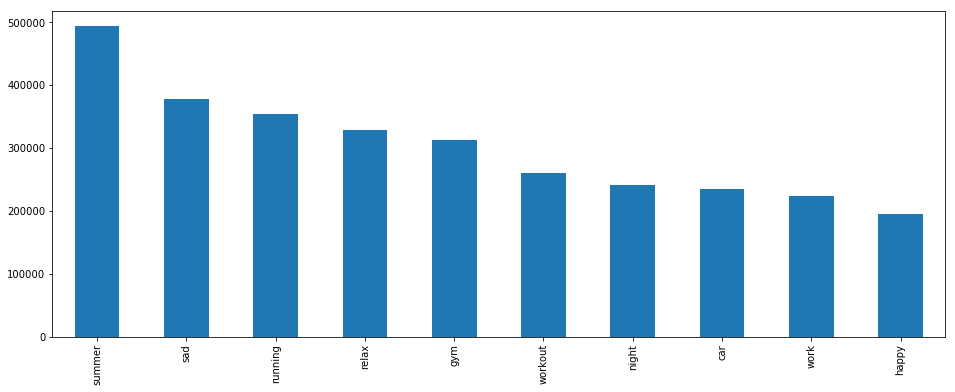

In [69]:
global_labels_clipped.iloc[:,2:].sum(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(16,6))

In [96]:
global_labels_clipped.to_csv(os.path.join(test_save_path, "all_labels_clipped.csv"), index = False )

In [72]:
train_binarized_clipped = train_binarized[['song_id', 'user_id', 'car', 'gym', 'happy',
       'night', 'relax', 'running', 'sad', 'summer', 'work',
       'workout']]

In [73]:
train_binarized_clipped = train_binarized_clipped[train_binarized_clipped.iloc[:,2:].sum(axis=1) != 0]

In [74]:
train_binarized_clipped_partial = train_binarized_clipped.iloc[0:100000,:]

In [97]:
train_binarized_clipped_partial.to_csv(os.path.join(test_save_path, "train_partial_clipped.csv"), index = False )

In [83]:
test_binarized_clipped = test_binarized[['song_id', 'user_id', 'car', 'gym', 'happy',
       'night', 'relax', 'running', 'sad', 'summer', 'work',
       'workout']]

In [84]:
test_binarized_clipped = test_binarized_clipped[test_binarized_clipped.iloc[:,2:].sum(axis=1) != 0]

In [85]:
test_binarized_clipped_partial = test_binarized_clipped.iloc[0:50000,:]

In [98]:
test_binarized_clipped_partial.to_csv(os.path.join(test_save_path, "test_partial_clipped.csv"), index = False )

In [87]:
validation_binarized_clipped = validation_binarized[['song_id', 'user_id', 'car', 'gym', 'happy',
       'night', 'relax', 'running', 'sad', 'summer', 'work',
       'workout']]

In [88]:
validation_binarized_clipped = validation_binarized_clipped[validation_binarized_clipped.iloc[:,2:].sum(axis=1) != 0]

In [89]:
validation_binarized_clipped_partial = validation_binarized_clipped.iloc[0:30000,:]

In [99]:
validation_binarized_clipped_partial.to_csv(os.path.join(test_save_path, "validation_partial_clipped.csv"), index = False )

In [95]:
len(train_binarized_clipped_partial.columns)

12

In [102]:
train_partial.song_id.nunique()

44598

In [ ]:
train_partial.user_id.nunique()

## Create splits with less users

In [131]:
# train
unique_users = train_binarized_clipped.groupby("user_id").count().sort_values("song_id",ascending = False).iloc[1:1000,:].index.values

In [132]:
active_training_labels = train_binarized_clipped[train_binarized_clipped.user_id.isin(unique_users)]

In [134]:
active_training_labels.to_csv(os.path.join(test_save_path, "train_active_clipped.csv"), index = False )

In [141]:
# test
unique_users = test_binarized_clipped.groupby("user_id").count().sort_values("song_id",ascending = False).iloc[1:1400,:].index.values

In [142]:
active_test_labels = test_binarized_clipped[test_binarized_clipped.user_id.isin(unique_users)]

In [144]:
active_test_labels.to_csv(os.path.join(test_save_path, "test_active_clipped.csv"), index = False )

In [157]:
# validation
unique_users = validation_binarized_clipped.groupby("user_id").count().sort_values("song_id",ascending = False).iloc[1:2300,:].index.values

In [158]:
active_validation_labels = validation_binarized_clipped[validation_binarized_clipped.user_id.isin(unique_users)]

In [160]:
active_validation_labels.to_csv(os.path.join(test_save_path, "validation_active_clipped.csv"), index = False )